# SXSW Tweets: Sentiment Analysis using NLP


**Authors**: Marcelo Scatena, Czarina Luna, Piotr Czolpik, Ross McKim

***
February 2022

<img src='images/header.jpeg' align='left'/>

[Image Source](https://www.hackreactor.com/blog/software-engineers-guide-to-sxsw-2021)

# Table of Contents
* [Summary](#Summary)
* [Business Problem](#Business_Problem)
* [Data Understanding](#Data_Understanding)
* [I. Data Exploration](#Data_Exploration)
* [II. Data Modeling](#Data_Modeling)    
    * [Baseline Model](#Baseline_Model)
    * [Machine Learning Pipeline](#Pipeline)
    * [Hyperparameter Tuning](#Hyperparameter_Tuning)
* [III. Final Model](#Final_Model)
* [IV. Results](#Results)
* [V. Recommendations](#Recommendations)
* [Next Steps](#Next_Steps)
* [Contact Us](#Contact)

# Summary <a class="anchor" id="Summary"></a>
The

# Business Problem <a class="anchor" id="Business_problem"></a>
The

# Data Understanding <a class="anchor" id="Data_Understanding"></a>
The 

# I. Data Exploration <a class="anchor" id="Data_Exploration"></a>
The

In [1]:
import pandas as pd

raw_data = pd.read_csv('./data/tweets.csv', encoding='latin1')
raw_data.head(2)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion


In [2]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
raw_data.columns = ['text', 'product', 'target']

In [4]:
raw_data.isnull().sum()

text          1
product    5802
target        0
dtype: int64

In [5]:
raw_data.duplicated().sum()

22

In [6]:
raw_data = raw_data.dropna(subset=['text']).drop_duplicates(subset=['text'])

In [7]:
raw_data['product'].value_counts(normalize=True)

iPad                               0.287500
Apple                              0.200915
iPad or iPhone App                 0.142988
Google                             0.130488
iPhone                             0.090244
Other Google product or service    0.089329
Android App                        0.024390
Android                            0.023476
Other Apple product or service     0.010671
Name: product, dtype: float64

In [8]:
raw_data['target'].value_counts(normalize=True)

No emotion toward brand or product    0.592609
Positive emotion                      0.327413
Negative emotion                      0.062769
I can't tell                          0.017209
Name: target, dtype: float64

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

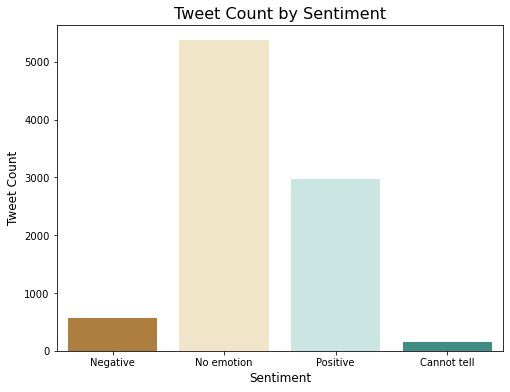

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x='target', data=raw_data, palette='BrBG', order=['Negative emotion', 'No emotion toward brand or product', 'Positive emotion', "I can't tell"])
ax.set_title('Tweet Count by Sentiment', fontsize=16)
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_xticklabels(['Negative', 'No emotion', 'Positive', 'Cannot tell'])
ax.set_ylabel('Tweet Count', fontsize=12)
plt.show()
# sns.color_palette(['#e7404a', '#29b874', '#f5cb39', '#4950ba'])

In [11]:
raw_data = raw_data.drop((raw_data.loc[raw_data['target']=="I can't tell"]).index)

In [12]:
apple_products = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service']
google_products = ['Google', 'Other Google product or service', 'Android App', 'Android']

raw_data['brand'] = raw_data['product'].apply(lambda x: 'google' if x in google_products else ('apple' if x in apple_products else 'unknown'))

In [13]:
pd.DataFrame(raw_data.groupby(['brand', 'target'])['text'].count())

text
brand   target                                  
apple   Negative emotion                     387
        No emotion toward brand or product    65
        Positive emotion                    1943
google  Negative emotion                     131
        No emotion toward brand or product    26
        Positive emotion                     719
unknown Negative emotion                      51
        No emotion toward brand or product  5281
        Positive emotion                     306

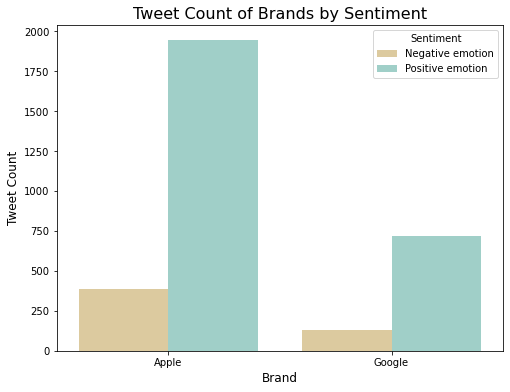

In [14]:
brand_only = raw_data.loc[(raw_data['brand']!='unknown') & (raw_data['target']!='No emotion toward brand or product')]

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x='brand', data=brand_only, hue='target', palette='BrBG')
ax.set_title('Tweet Count of Brands by Sentiment', fontsize=16)
ax.set_xlabel('Brand', fontsize=12)
ax.set_xticklabels(['Apple', 'Google'])
ax.set_ylabel('Tweet Count', fontsize=12)
ax.legend(['Negative', 'Positive'])
plt.legend(title='Sentiment')
plt.show()

In [15]:
target_values = {'No emotion toward brand or product':1, 'Positive emotion':2, 'Negative emotion':0}

raw_data['target'] = raw_data['target'].map(target_values)

In [16]:
raw_data['words'] = raw_data['text'].apply(lambda x: len(x.split()))
raw_data['char'] = raw_data['text'].apply(lambda x: len(x))

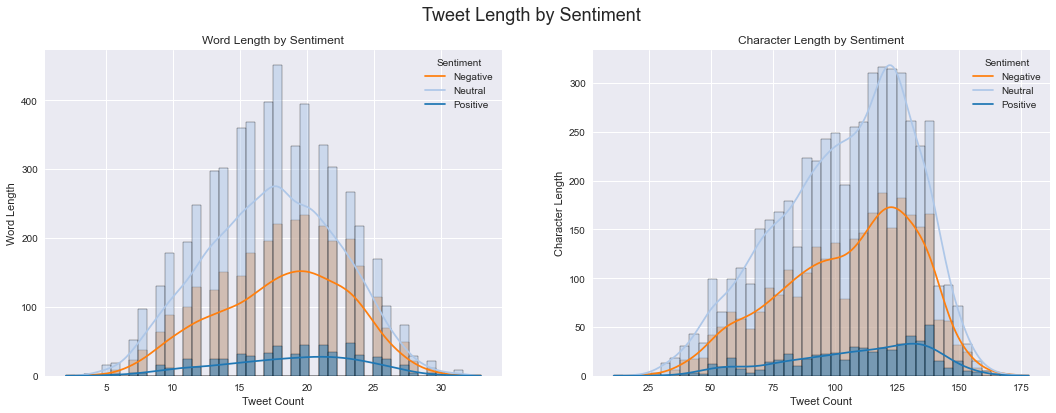

In [17]:
plt.style.use('seaborn')

fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
fig.suptitle('Tweet Length by Sentiment', fontsize=18)

sns.histplot(x='words', data=raw_data, bins='auto', kde=True, hue='target', legend=True, ax=axes[0], palette='tab20')
axes[0].set_title('Word Length by Sentiment')
axes[0].set_xlabel('Tweet Count')
axes[0].set_ylabel('Word Length')
axes[0].legend(['Negative', 'Neutral', 'Positive'], title='Sentiment')

sns.histplot(x='char', data=raw_data, bins='auto', kde=True, hue='target', legend=True, ax=axes[1], palette='tab20')
axes[1].set_title('Character Length by Sentiment')
axes[1].set_xlabel('Tweet Count')
axes[1].set_ylabel('Character Length')
axes[1].legend(['Negative', 'Neutral', 'Positive'], title='Sentiment')

plt.show()

## Train Test Split

In [18]:
from sklearn.model_selection import train_test_split
X = raw_data['text']
y = raw_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112221, stratify=y)

In [96]:
%store X

Stored 'X' (Series)


In [97]:
%store y

Stored 'y' (Series)


In [19]:
%store y_train

Stored 'y_train' (Series)


In [20]:
%store y_test

Stored 'y_test' (Series)


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')

raw_words = cv.fit_transform(X_train)
raw_sum = raw_words.sum(axis=0)

raw_freq = [(word.title(), raw_sum[0, i]) for word, i in cv.vocabulary_.items()]
raw_freq = sorted(raw_freq, key=lambda x: x[1], reverse=True)
words_freq = pd.DataFrame(raw_freq, columns=['word', 'frequency'])

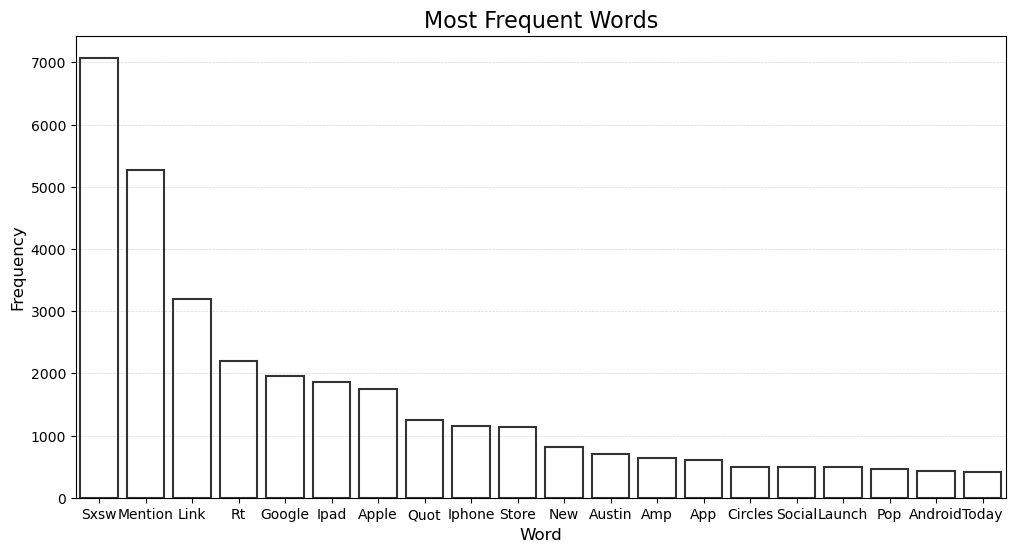

In [22]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='word', y='frequency', data=words_freq.head(20), linewidth=1.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2", zorder=3)
ax.set_title('Most Frequent Words', fontsize=16)
ax.set_xlabel('Word', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)

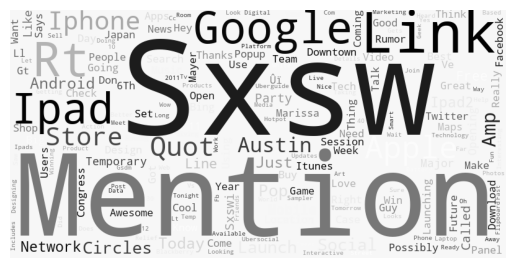

In [23]:
from wordcloud import WordCloud

raw_wordcloud = WordCloud(background_color='#f7f7f7', width=800, height=400, colormap='Greys_r', random_state=1).generate_from_frequencies(dict(raw_freq))

plt.figure()
plt.imshow(raw_wordcloud)
#plt.title('SXSW Tweets Word Cloud')
plt.axis('off')
plt.show()

In [24]:
train_sample = pd.DataFrame(X_train.sample(5, random_state=112221))
train_sample['label'] = [y_train[val] for val in train_sample.index]
train_sample

,text,label
5758,RT @mention Funny that even CNN is saying to s...,1
7358,Vinh: Flipboard is a step forward for iPad mag...,2
6306,RT @mention Mayer: 20% of Google searches are ...,1
4092,&quot;Apple is the most elegant fascist compan...,0
2369,It's official! I'm buying an iPad. #SXSW #elevate,2


In [25]:
import regex as re
import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['sxsw','sxswi', 'link', 'quot', 'rt'])

lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess(text):
    text = text.apply(lambda x: x.lower()).str.encode('ascii', 'ignore').str.decode('ascii')
    text = text.apply(lambda x: re.sub(r'http\S+', '', x)).apply(lambda x: re.sub(r'@\S*', '', x))

    text = text.apply(lambda x: re.split('\W+', x))
    text = text.apply(lambda x: [''.join(letter for letter in word if letter not in string.punctuation) for word in x])
    text = text.apply(lambda x: [word for word in x if word not in stopwords])
     
    return text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x]).apply(lambda x: ' '.join(x))

In [26]:
train_sample['text'] = preprocess(train_sample['text'])
train_sample

,text,label
5758,funny even cnn saying stay clear austin apple ...,1
7358,vinh flipboard step forward ipad mag get right...,2
6306,mayer 20 google search local information pr,1
4092,apple elegant fascist company america flipboard,0
2369,official buying ipad elevate,2


## Transforming Data

In [27]:
X_train_processed = preprocess(X_train)
X_test_processed = preprocess(X_test)

In [28]:
%store X_train_processed

Stored 'X_train_processed' (Series)


In [29]:
%store X_test_processed

Stored 'X_test_processed' (Series)


In [30]:
processed_words = cv.fit_transform(X_train_processed)
processed_sum = processed_words.sum(axis=0)

processed_freq = [(word.title(), processed_sum[0, i]) for word, i in cv.vocabulary_.items()]
processed_freq = sorted(processed_freq, key=lambda x: x[1], reverse=True)
processed_words_freq = pd.DataFrame(processed_freq, columns=['word', 'frequency'])

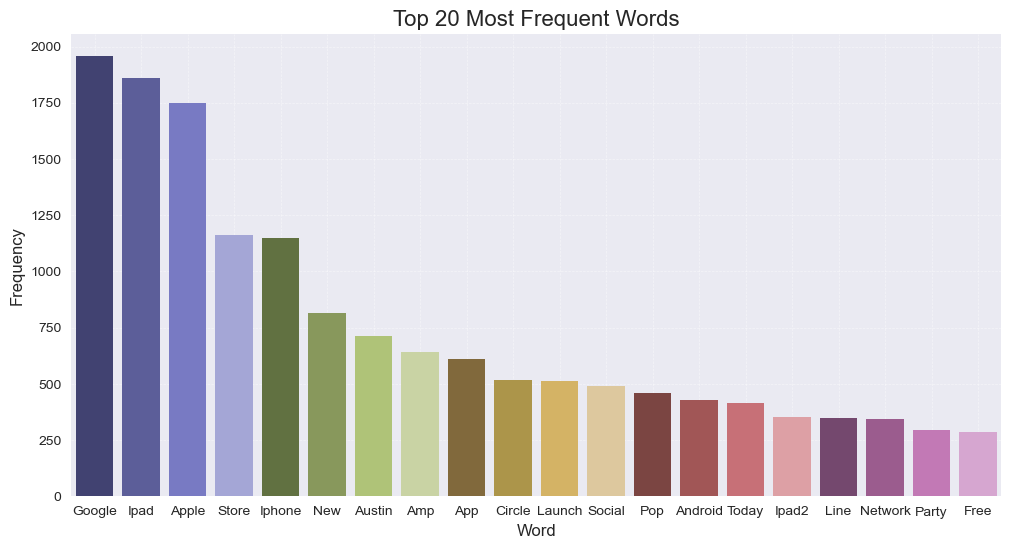

In [31]:
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='word', y='frequency', data=processed_words_freq.head(20), palette='tab20b', zorder=3)
ax.set_title('Top 20 Most Frequent Words', fontsize=16)
ax.set_xlabel('Word', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.grid(linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)

In [32]:
train_set_processed = pd.concat([X_train_processed, y_train], axis=1)

In [33]:
from nltk.tokenize import RegexpTokenizer
regex_token = RegexpTokenizer(r'\w+')

sentiment_dict = {}
for idx, name in enumerate(['negative_target', 'neutral_target', 'positive_target']):
    sentiment_text = train_set_processed['text'].loc[train_set_processed['target']==idx].tolist()
    sentiment_data = ' '.join(sentiment_text)
    sentiment_dict[name] = set(regex_token.tokenize(sentiment_data))

In [34]:
str_negative = ' '.join(sentiment_dict['negative_target'])
str_neutral = ' '.join(sentiment_dict['neutral_target'])
str_positive = ' '.join(sentiment_dict['positive_target'])

# unique_negative = ' '.join(A-(B|C))
# unique_neutral = ' '.join(B-(A|C))
# unique_positive = ' '.join(C-(A|B))

In [35]:
from PIL import Image
import numpy as np

In [36]:
def create_wordcloud(str_sentiment, filename, color, bg_color='black', contour_color=None, contour_width=0, random_state=1):
    mask = np.array(Image.open(f'images/{filename}'))
    
    wc = WordCloud(max_font_size=175, width=1000, height=1000, mask=mask, max_words=125, colormap=color, 
                   background_color=bg_color, contour_color=contour_color, contour_width=contour_width,
                   random_state=random_state).generate(str_sentiment)

    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

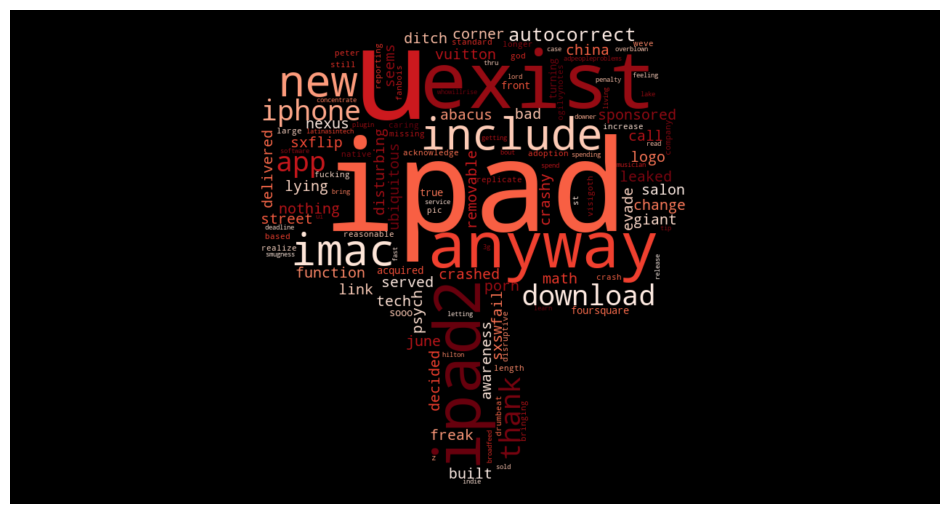

In [37]:
#create_wordcloud(str_negative, 'negative.jpeg', 'Reds_r', 'white', 'darkred', 50)
create_wordcloud(str_negative, 'negative.jpeg', 'Reds_r', 'black')

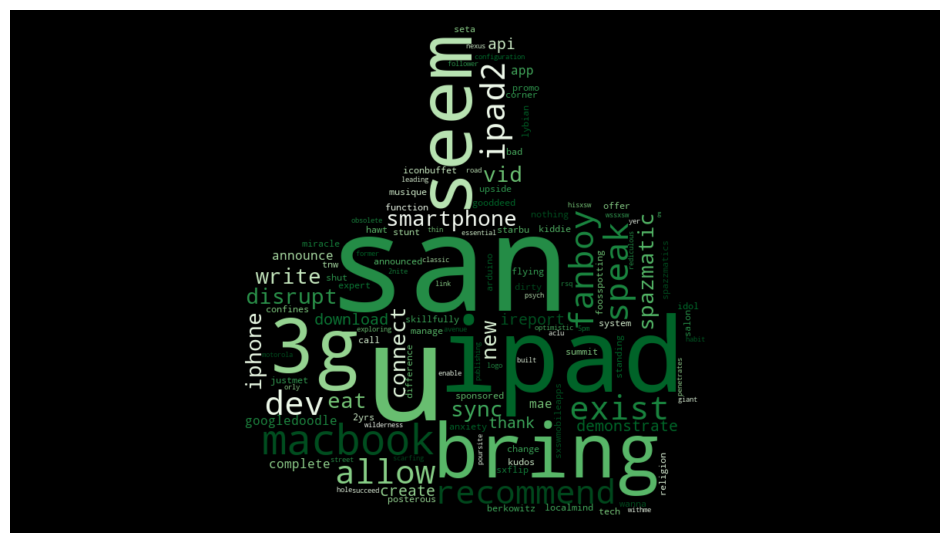

In [38]:
#create_wordcloud(str_positive, 'positive.jpeg', 'Greens_r', 'white', 'darkgreen', 50)
create_wordcloud(str_positive, 'positive.jpeg', 'Greens_r', 'black')

In [39]:
brand_dict = {}
for brand in ['apple', 'google']:
    brand_text = train_set_processed['text'].loc[raw_data.loc[X_train_processed.index,'brand']==brand].tolist()
    brand_data = ' '.join(brand_text)
    brand_dict[brand] = set(regex_token.tokenize(brand_data))
    
str_apple = ' '.join(brand_dict['apple'])
str_google = ' '.join(brand_dict['google'])

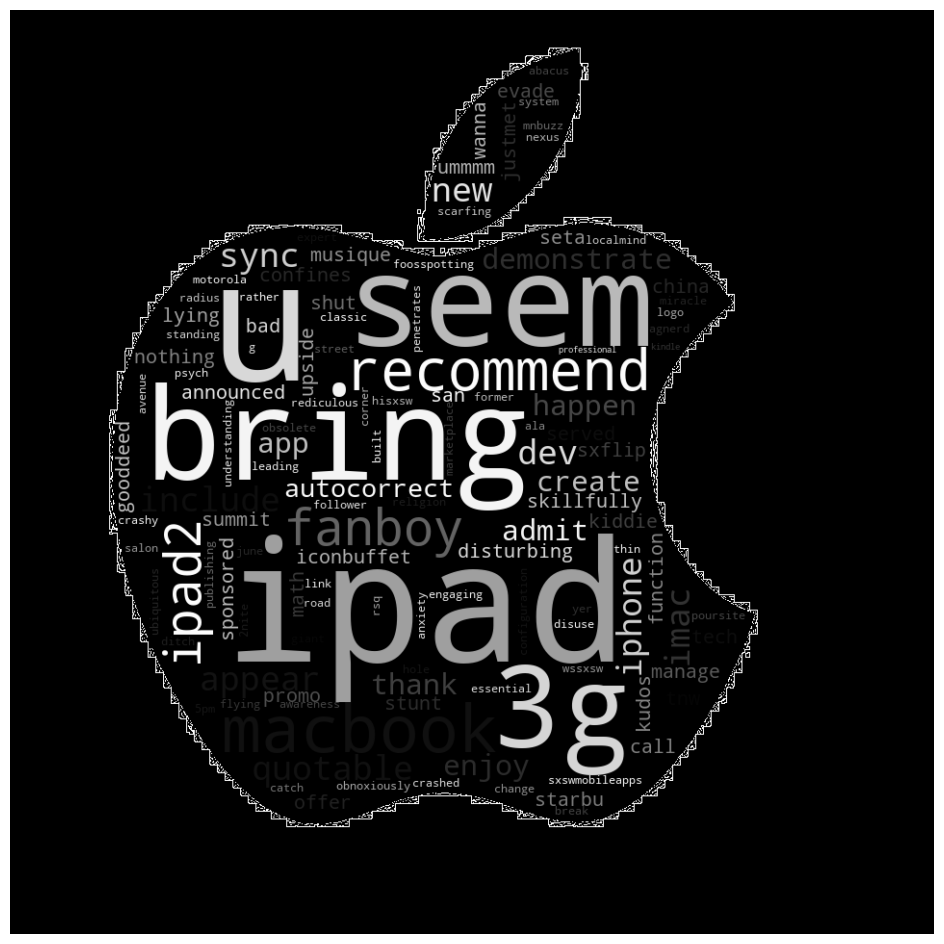

In [40]:
#create_wordcloud(str_apple, 'apple.jpeg', 'Greys_r', 'white', 'black', 15)
create_wordcloud(str_apple, 'apple.jpeg', 'Greys', 'black', 'white', .1)

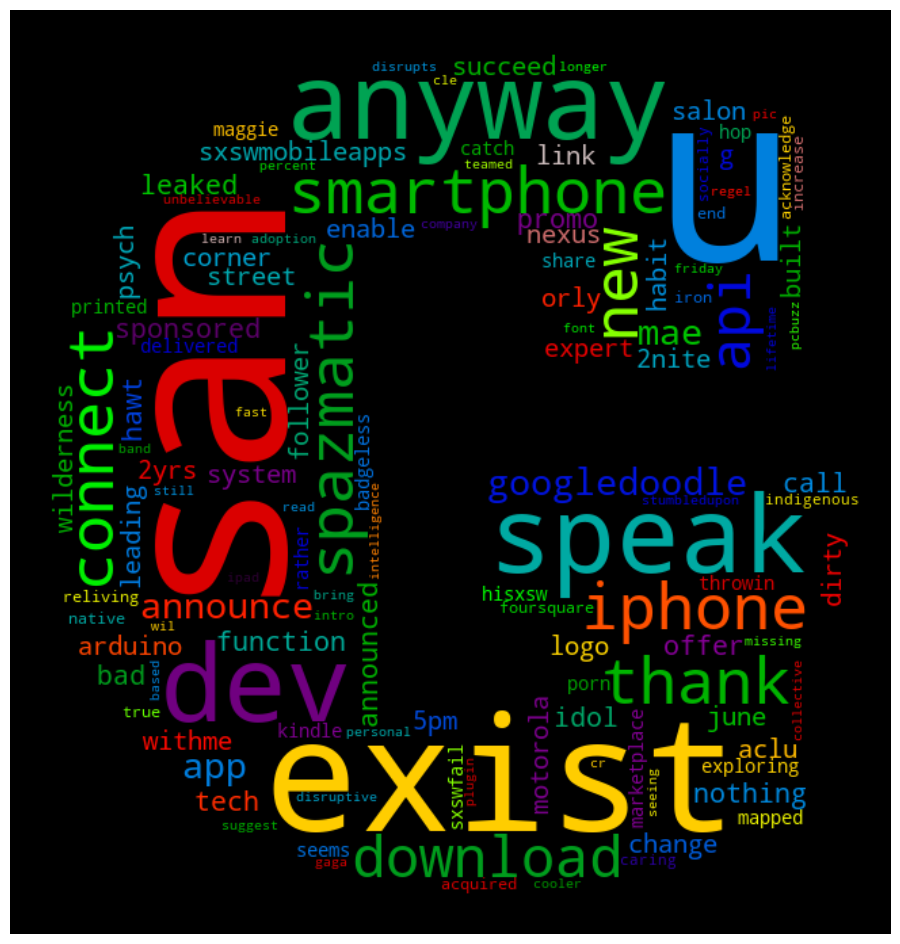

In [41]:
create_wordcloud(str_google, 'google.jpeg', 'nipy_spectral_r', random_state=2)

## Word2Vec

In [42]:
from gensim.models import Word2Vec
from nltk import word_tokenize

In [43]:
X_train_w2v = X_train_processed.map(word_tokenize)

w2v_model = Word2Vec(X_train_w2v, window=5, min_count=1, workers=4)
w2v_model.train(X_train_w2v, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

wv = w2v_model.wv

def show_most_similar(word, length=10):
    return wv.most_similar(word, topn=length)

## Examine Word Vectors

In [44]:
show_most_similar('apple')

[('ipad2', 0.9980095028877258),
 ('open', 0.9970500469207764),
 ('congress', 0.9965457916259766),
 ('presence', 0.9959943294525146),
 ('shop', 0.9957894682884216),
 ('sell', 0.9954895973205566),
 ('pop', 0.9952161312103271),
 ('store', 0.994881272315979),
 ('set', 0.994740903377533),
 ('austin', 0.994648814201355)]

In [45]:
show_most_similar('google', 5)

[('kek', 0.9913201332092285),
 ('ht', 0.9902340173721313),
 ('average', 0.9851391911506653),
 ('product', 0.9814146161079407),
 ('loosing', 0.9810601472854614)]

In [46]:
show_most_similar('iphone', 5)

[('app', 0.9931755065917969),
 ('parenting', 0.9767811298370361),
 ('yayrt', 0.9748337268829346),
 ('solve', 0.9741776585578918),
 ('newly', 0.9735585451126099)]

In [47]:
show_most_similar('android', 5)

[('bizzy', 0.9949283003807068),
 ('blackberry', 0.9888833165168762),
 ('taste', 0.9835392832756042),
 ('evo', 0.981709361076355),
 ('deleting', 0.9812341332435608)]

In [48]:
show_most_similar('ipad')

[('money', 0.9848863482475281),
 ('win', 0.9831383228302002),
 ('get', 0.9780991077423096),
 ('2', 0.9774224758148193),
 ('christmas', 0.9748365879058838),
 ('chance', 0.9737773537635803),
 ('sad', 0.97246253490448),
 ('selling', 0.9719375371932983),
 ('ip', 0.9717758893966675),
 ('somewhere', 0.9716598391532898)]

In [49]:
from nltk.collocations import * # ?
from nltk import TweetTokenizer

tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

X_train_twt = tweet_tokenizer.tokenize(' '.join(X_train_w2v.apply(lambda x: ' '.join(x))))

In [50]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(X_train_twt)
bigrams = finder.score_ngrams(bigram_measures.raw_freq)

In [51]:
bigrams[:50]

[(('ipad', '2'), 0.017026246235171183),
 (('apple', 'store'), 0.007099391480730223),
 (('social', 'network'), 0.005193927100620813),
 (('new', 'social'), 0.004748294302046837),
 (('pop', 'store'), 0.004364128096379618),
 (('google', 'launch'), 0.003641895629725244),
 (('called', 'circle'), 0.0036265289814985556),
 (('network', 'called'), 0.0035804290368184892),
 (('iphone', 'app'), 0.0034728624992316675),
 (('major', 'new'), 0.0031962628311512694),
 (('launch', 'major'), 0.0031040629417911367),
 (('apple', 'opening'), 0.0027659966808039832),
 (('apple', 'pop'), 0.002750630032577294),
 (('google', 'circle'), 0.002704530087897228),
 (('possibly', 'today'), 0.0025969635503104065),
 (('circle', 'possibly'), 0.002566230253857029),
 (('store', 'austin'), 0.0024125637715901407),
 (('temporary', 'store'), 0.0023049972340033194),
 (('google', 'map'), 0.0022281639928698753),
 (('downtown', 'austin'), 0.0022127973446431862),
 (('marissa', 'mayer'), 0.0020898641588296763),
 (('2', 'launch'), 0.002

# II. Data Modeling <a class="anchor" id="Data_Modeling"></a>
The

## Baseline Model <a class="anchor" id="Baseline_Model"></a>

## Pipeline <a class="anchor" id="Pipeline"></a>

In [52]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [84]:
ros = RandomOverSampler(random_state=112221)
cv = CountVectorizer(lowercase=False)
tfidf = TfidfVectorizer(stop_words='english', lowercase=False)

def run_model(dict_model, type_, vectorizer, rosample=False):
    X = raw_data['text']
    y = raw_data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112221, stratify=y)
    
    X_train = preprocess(X_train)
    X_test = preprocess(X_test)
    
    metric_table = pd.DataFrame(columns=['Model', 'CV Score', 'Accuracy', 'Type'])

    for name, model in dict_model.items():
        print(f'Running... {name} Model:')
        if rosample:
            X_train_ros, y_train_ros = ros.fit_resample(np.array(X_train).reshape(-1, 1), y_train)
    
            pipeline = Pipeline(steps=[(str(vectorizer), vectorizer), ('classifier', model['classifier'])])
            pipeline.fit(X_train_ros, y_train_ros) 

            y_pred = pipeline.predict(X_test)
            y_score = pipeline.predict_proba(X_test)[:,1] 

            cv_score = cross_val_score(pipeline, X_train_ros, y_train_ros, cv=3)
            cv_score_mean = round(np.mean(cv_score), 4)
        
            accuracy = accuracy_score(y_test, y_pred)
        else:
            pipeline = Pipeline(steps=[(str(vectorizer), vectorizer), ('classifier', model['classifier'])])
            pipeline.fit(X_train, y_train) 

            y_pred = pipeline.predict(X_test)
            y_score = pipeline.predict_proba(X_test)[:,1] 

            cv_score = cross_val_score(pipeline, X_train, y_train, cv=3)
            cv_score_mean = round(np.mean(cv_score), 4)

            accuracy = accuracy_score(y_test, y_pred)
            
        metric_table = metric_table.append({'Model': name, 'CV Score': cv_score_mean, 'Accuracy': round(accuracy, 4), 'Type': type_}, ignore_index=True)
        
        print(f'Cross Validation Score: {metric_table.iloc[-1,1]}')
        print(f'Test Accuracy Score: {metric_table.iloc[-1,2]}\n')
    
    return metric_table

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [55]:
baseline_models = {'LogisticRegression': {'classifier': LogisticRegression(max_iter=1000, random_state=20211122)}, 
                   'MultinomialNB': {'classifier': MultinomialNB()},
                   'DecisionTree': {'classifier': DecisionTreeClassifier(random_state=20211122)},
                   'RandomForest': {'classifier': RandomForestClassifier(random_state=20211122)},
                   'ExtraTrees': {'classifier': ExtraTreesClassifier(random_state=20211122)},
                   'GradientBoost': {'classifier': GradientBoostingClassifier(random_state=20211122)}
                  }

In [63]:
baseline_cv_table = run_model(baseline_models, 'CV', cv)
baseline_cv_table

Running... LogisticRegression Model:
Cross Validation Score: 0.6724
Test Accuracy Score: 0.6863

Running... MultinomialNB Model:
Cross Validation Score: 0.6538
Test Accuracy Score: 0.6607

Running... DecisionTree Model:
Cross Validation Score: 0.6399
Test Accuracy Score: 0.6629

Running... RandomForest Model:
Cross Validation Score: 0.6691
Test Accuracy Score: 0.6849

Running... ExtraTrees Model:
Cross Validation Score: 0.6824
Test Accuracy Score: 0.675

Running... GradientBoost Model:
Cross Validation Score: 0.6653
Test Accuracy Score: 0.6679



,Model,CV Score,Accuracy,Precision,Recall,F1 Score,Type
0,LogisticRegression,0.6724,0.6863,0.6863,0.6863,0.6863,CV
1,MultinomialNB,0.6538,0.6607,0.6607,0.6607,0.6607,CV
2,DecisionTree,0.6399,0.6629,0.6629,0.6629,0.6629,CV
3,RandomForest,0.6691,0.6849,0.6849,0.6849,0.6849,CV
4,ExtraTrees,0.6824,0.6750,0.6750,0.6750,0.6750,CV
5,GradientBoost,0.6653,0.6679,0.6679,0.6679,0.6679,CV


In [77]:
lr = {'LogisticRegression': {'classifier': LogisticRegression(max_iter=1000, random_state=20211122)}}

In [85]:
baseline_cv_ros_table = run_model(lr, 'CV ROS', cv, rosample=True)
baseline_cv_ros_table

Running... LogisticRegression Model:


TypeError: cannot use a string pattern on a bytes-like object

In [64]:
baseline_tfidf_table = run_model(baseline_models, 'TFIDF', tfidf)
baseline_tfidf_table

Running... LogisticRegression Model:
Cross Validation Score: 0.6768
Test Accuracy Score: 0.6957

Running... MultinomialNB Model:
Cross Validation Score: 0.6496
Test Accuracy Score: 0.6607

Running... DecisionTree Model:
Cross Validation Score: 0.6156
Test Accuracy Score: 0.6571

Running... RandomForest Model:
Cross Validation Score: 0.6692
Test Accuracy Score: 0.6899

Running... ExtraTrees Model:
Cross Validation Score: 0.6779
Test Accuracy Score: 0.6903

Running... GradientBoost Model:
Cross Validation Score: 0.6635
Test Accuracy Score: 0.6656



,Model,CV Score,Accuracy,Precision,Recall,F1 Score,Type
0,LogisticRegression,0.6768,0.6957,0.6957,0.6957,0.6957,TFIDF
1,MultinomialNB,0.6496,0.6607,0.6607,0.6607,0.6607,TFIDF
2,DecisionTree,0.6156,0.6571,0.6571,0.6571,0.6571,TFIDF
3,RandomForest,0.6692,0.6899,0.6899,0.6899,0.6899,TFIDF
4,ExtraTrees,0.6779,0.6903,0.6903,0.6903,0.6903,TFIDF
5,GradientBoost,0.6635,0.6656,0.6656,0.6656,0.6656,TFIDF


In [59]:
baseline_tfidf_ros_table = run_model(baseline_models, 'TFIDF ROS', tfidf, rosample=True)
baseline_tfidf_ros_table

Running... LogisticRegression Model:
Cross Validation Score: 0.6768
Test Accuracy Score: 0.6957

Running... MultinomialNB Model:
Cross Validation Score: 0.6496
Test Accuracy Score: 0.6607

Running... DecisionTree Model:
Cross Validation Score: 0.6156
Test Accuracy Score: 0.6571

Running... RandomForest Model:
Cross Validation Score: 0.6692
Test Accuracy Score: 0.6899

Running... ExtraTrees Model:
Cross Validation Score: 0.6779
Test Accuracy Score: 0.6903

Running... GradientBoost Model:
Cross Validation Score: 0.6635
Test Accuracy Score: 0.6656



,Model,CV Score,Accuracy,Precision,Recall,F1 Score,Type
0,LogisticRegression,0.6768,0.6957,0.6957,0.6957,0.6957,TFIDF ROS
1,MultinomialNB,0.6496,0.6607,0.6607,0.6607,0.6607,TFIDF ROS
2,DecisionTree,0.6156,0.6571,0.6571,0.6571,0.6571,TFIDF ROS
3,RandomForest,0.6692,0.6899,0.6899,0.6899,0.6899,TFIDF ROS
4,ExtraTrees,0.6779,0.6903,0.6903,0.6903,0.6903,TFIDF ROS
5,GradientBoost,0.6635,0.6656,0.6656,0.6656,0.6656,TFIDF ROS


In [87]:
all_tables = pd.concat([baseline_cv_table, baseline_tfidf_table], ignore_index=True)
all_tables['Name'] = all_tables['Model'] + ' ' + all_tables['Type']
all_tables = all_tables[['Model', 'CV Score', 'Accuracy', 'Type', 'Name']]

In [88]:
all_tables

,Model,CV Score,Accuracy,Type,Name
0,LogisticRegression,0.6724,0.6863,CV,LogisticRegression CV
1,MultinomialNB,0.6538,0.6607,CV,MultinomialNB CV
2,DecisionTree,0.6399,0.6629,CV,DecisionTree CV
3,RandomForest,0.6691,0.6849,CV,RandomForest CV
4,ExtraTrees,0.6824,0.6750,CV,ExtraTrees CV
5,GradientBoost,0.6653,0.6679,CV,GradientBoost CV
6,LogisticRegression,0.6768,0.6957,TFIDF,LogisticRegression TFIDF
7,MultinomialNB,0.6496,0.6607,TFIDF,MultinomialNB TFIDF
8,DecisionTree,0.6156,0.6571,TFIDF,DecisionTree TFIDF
9,RandomForest,0.6692,0.6899,TFIDF,RandomForest TFIDF


In [108]:
rnn1 = {'Model': 'ARNNmy', 'CV Score': 89, 'Accuracy': 0.67, 'Type': 'CV', 'Name': 'RecurrentNeuralNetwork'}
#rnn2 = {'Model': 'AmRNNy', 'CV Score': 89, 'Accuracy': 93, 'Type': , 'NeuralNetwork': ,}
all_tables = all_tables.append(rnn1, ignore_index = True)

In [ ]:
all_tables = 

In [ ]:
all_tables

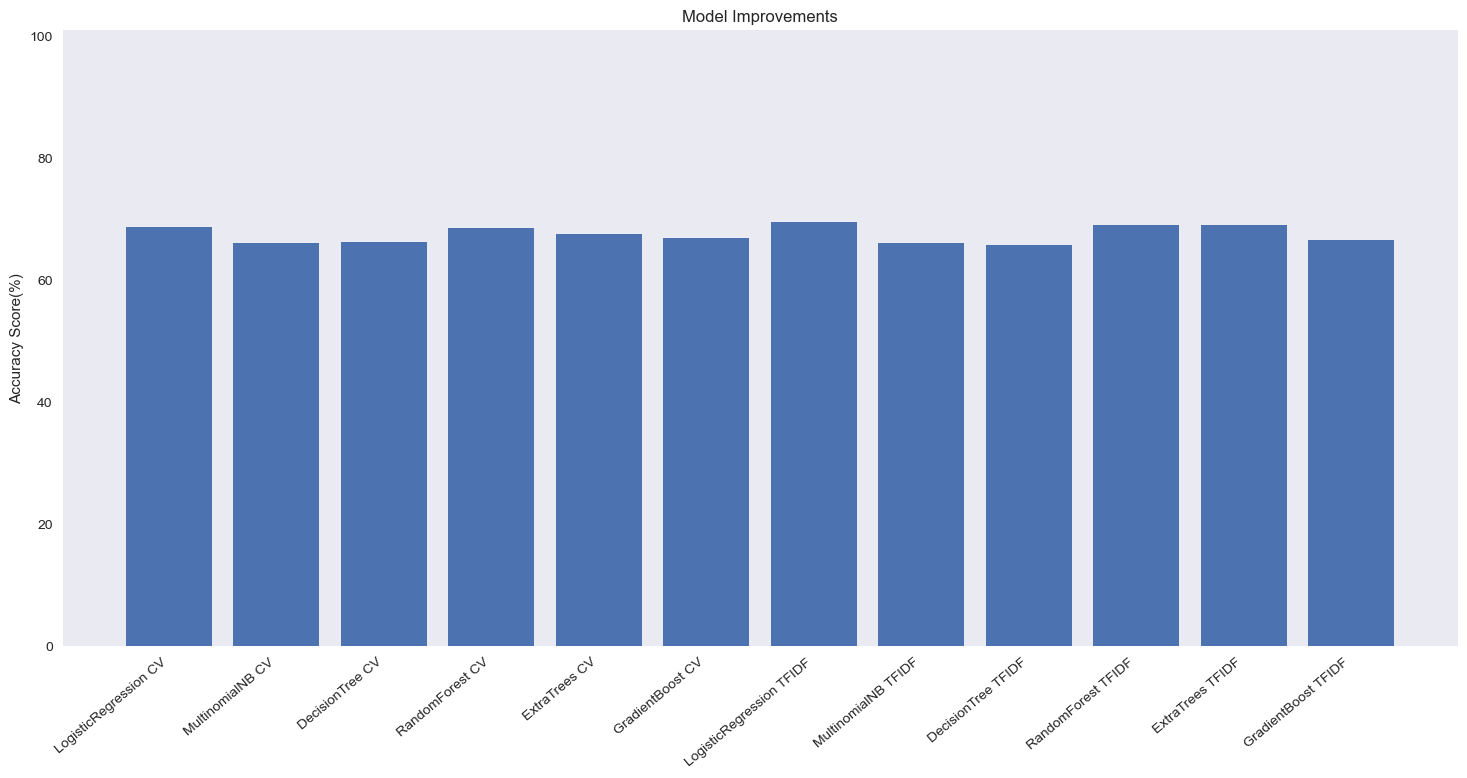

In [98]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(18, 8))

plt.bar(all_tables['Name'], (all_tables['Accuracy'])*100, label='Accuracy')

plt.ylim(0, 101)
plt.grid(False)
plt.xticks(rotation=40, ha='right')
plt.ylabel('Accuracy Score(%)')
plt.title('Model Improvements')
plt.show()

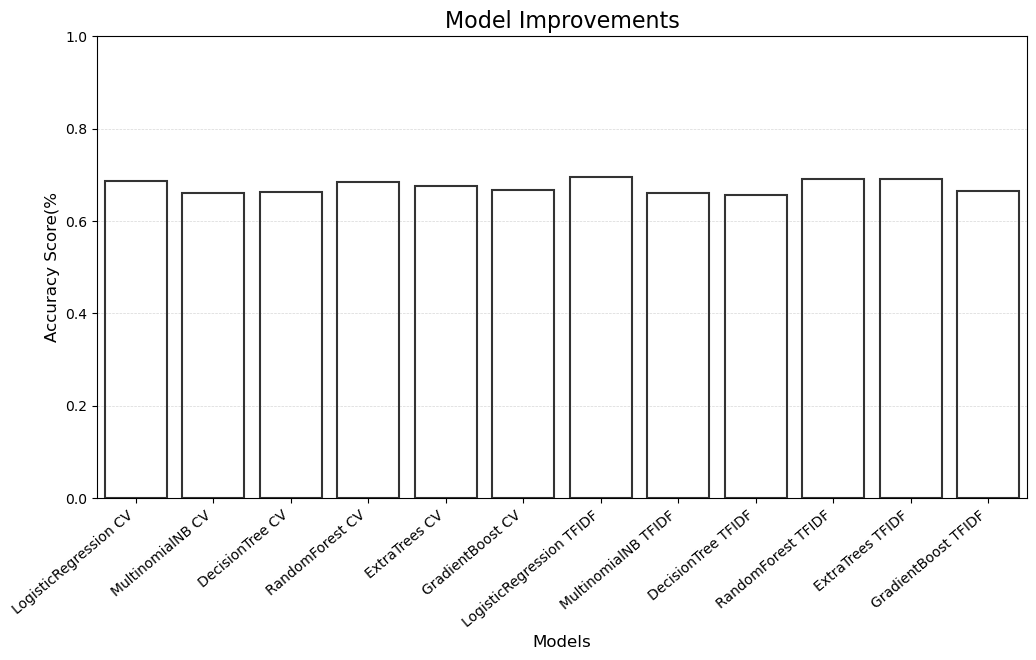

In [105]:
plt.style.use('default')

# plt.bar(all_tables['Name'], (all_tables['Accuracy'])*100, label='Accuracy')

# plt.ylim(0, 101)
# plt.grid(False)
# plt.xticks(rotation=40, ha='right')
# plt.ylabel('Accuracy Score(%)')
# plt.title('Model Improvements')
# plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='Name', y='Accuracy', data=all_tables, linewidth=1.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2", zorder=3)
ax.set_title('Model Improvements', fontsize=16)
ax.set_xlabel('Models', fontsize=12)
plt.xticks(rotation=40, ha='right')
plt.ylim(0, 1)
ax.set_ylabel('Accuracy Score(%', fontsize=12)
plt.grid(axis='y', linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)

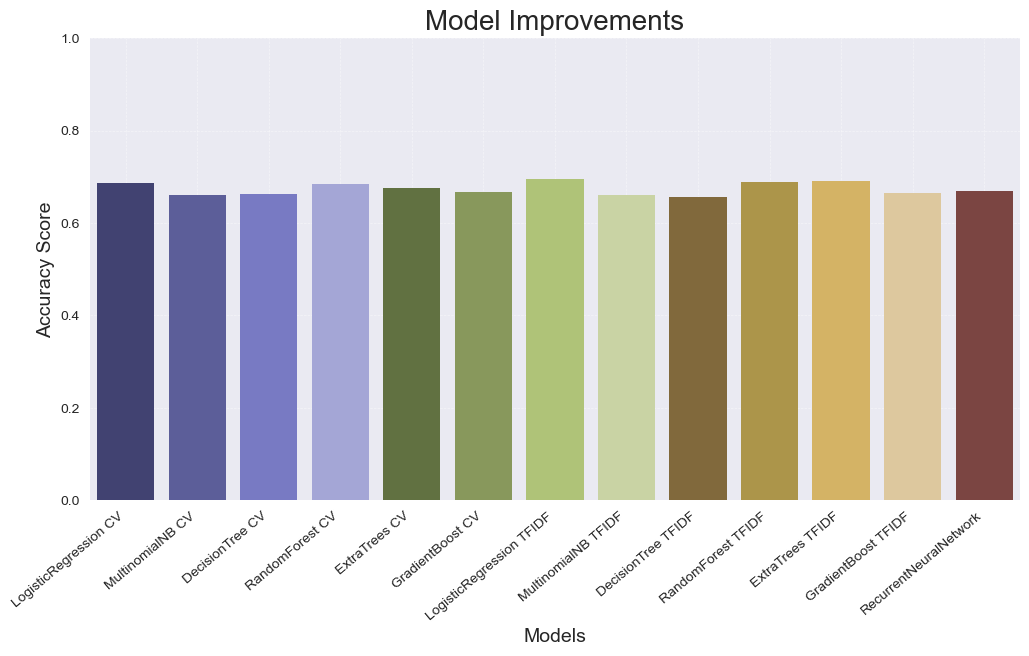

In [112]:
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='Name', y='Accuracy', data=all_tables, palette='tab20b', zorder=3)
ax.set_title('Model Improvements', fontsize=20)
ax.set_xlabel('Models', fontsize=14)
plt.xticks(rotation=40, ha='right')
plt.ylim(0, 1)
ax.set_ylabel('Accuracy Score', fontsize=14)
plt.grid(linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)

## Hyperparameter Tuning <a class="anchor" id="Hyperparameter_Tuning"></a>

In [60]:
def tune_hyperparameters(dict_model, classifier, classifier_name, params):
    best_params = {}
    for param, values in params.items():
        parameter = param.replace('classifier__', '')
        best_params[parameter] = values
    dict_model[classifier_name]['classifier'] = classifier(**best_params)

In [61]:
# Make a copy of the dictionary of baseline models for tuned models
tuned_models = baseline_models.copy()

### Neural network

## Visualizing Word Embeddings

# III. Final Model <a class="anchor" id="Final_Model"></a>


### Test set evaluation

# IV. Results <a class="anchor" id="Results"></a>
The

# V. Recommendations <a class="anchor" id="Recommendations"></a>
The

## Next Steps <a class="anchor" id="Next_Steps"></a>
The

# Contact Us <a class="anchor" id="Contact"></a>
#